# Model Stealing Attack



### Introduction
This notebook demonstrates how to perform a model stealing attack against a trained machine learning model. Model stealing attacks attempt to create a "surrogate" model that replicates the behavior of a target model by observing its inputs and outputs. This type of attack is particularly relevant when the target model is only accessible through an API.

### Background
Model stealing attacks are a type of security threat where an adversary tries to duplicate the functionality of a machine learning model they only have black-box access to. The attacker queries the target model with carefully chosen inputs and uses the responses to train their own copycat model.
The key components are:

<b>Target Model</b>: The victim model we want to steal (accessed via API)

<b>Query Strategy</b>: How we generate inputs to extract knowledge from the target

<b>Surrogate Model</b>: Our duplicate model trained on target model's input/output pairs



In [1]:
%%html
<h3>Emplementation</h3>
<iframe src="assets/daigram1.png" width="600" height="500"></iframe>

## 0. Libraries Import

In [58]:
import tensorflow as tf
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

## 1. Configuration
We'll set up the basic parameters for our attack:
- API URL: Where the victim model is hosted


In [59]:
# Configuration
API_URL = "http://localhost:5000/predict"

## 2. Multiple surrogate architectures


This class sets up the foundation for a model stealing attack, which is a type of attack where an adversary attempts to recreate the functionality of a "black-box" machine learning model by querying it with inputs and observing its outputs. The adversary then uses these input-output pairs to train a surrogate model that mimics the behavior of the target model.

In [60]:
class ModelStealingAttack:
    def __init__(self, input_shape=(28, 28, 1), num_classes=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.target_predictions = []


The method sends a request to a remote machine learning model API and retrieves its prediction probabilities. This is a fundamental step in model stealing: obtaining outputs from the target model that will later be used to train the surrogate model.

In [61]:
def query_target_model(self, image):
    """Query the target model API"""
    try:
        response = requests.post(
            API_URL,
            json={'image': image.reshape(28, 28).tolist()}
        )
        return np.array(response.json()['full_probabilities'])
    except Exception as e:
        print(f"Error querying model: {e}")
        return None

# Attach the method to the class dynamically
ModelStealingAttack.query_target_model = query_target_model


The method builds a convolutional neural network (CNN) designed specifically for image classification tasks. The architecture is designed to balance complexity and performance - it needs to be powerful enough to learn the target model's behavior but not unnecessarily complex.

In [62]:
def create_surrogate_model(self):
    """Create a simpler surrogate model"""
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
                             input_shape=self.input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(self.num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Attach the method to the class dynamically
ModelStealingAttack.create_surrogate_model = create_surrogate_model


## 3: Helper Functions
We define helper functions to:
- Evaluate the success of our model stealing attack


In [63]:
def evaluate_stealing(surrogate_preds, target_preds, true_labels):
    """Evaluate model stealing success"""
    surrogate_classes = np.argmax(surrogate_preds, axis=1)
    target_classes = np.argmax(target_preds, axis=1)
    
    results = {
        'accuracy': np.mean(surrogate_classes == true_labels),
        'agreement': np.mean(surrogate_classes == target_classes),
        'confidence_correlation': np.corrcoef(
            np.max(surrogate_preds, axis=1),
            np.max(target_preds, axis=1)
        )[0, 1]
    }
    return results


- Compare predictions between target and surrogate models
- Visualize results

In [64]:

def plot_comparison(sample_image, target_pred, surrogate_pred, true_label):
    """Visualize predictions comparison"""
    plt.figure(figsize=(15, 4))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(sample_image.reshape(28, 28), cmap='gray')
    plt.title(f'True Label: {true_label}')
    plt.axis('off')
    
    # Target Model Prediction
    plt.subplot(1, 3, 2)
    plt.bar(range(10), target_pred)
    plt.title(f'Target Model\nPrediction: {np.argmax(target_pred)}')
    plt.ylim(0, 1)
    
    # Surrogate Model Prediction
    plt.subplot(1, 3, 3)
    plt.bar(range(10), surrogate_pred)
    plt.title(f'Surrogate Model\nPrediction: {np.argmax(surrogate_pred)}')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

## 4: Load and Prepare Data
We load the MNIST dataset and prepare it for both querying the target model and training our surrogate model.

In [65]:
# Load MNIST dataset
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print("Data shapes:")
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")

Loading MNIST dataset...
Data shapes:
x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


## 5: Query Target Model
We systematically query the target model with our inputs to collect training data for our surrogate model. We monitor the progress and validate the collected predictions.

In [66]:
# Initialize attack
attack = ModelStealingAttack()

# Query target model
print("Querying target model...")
num_samples = 2000  # Number of samples to use
target_predictions = []

# Simple progress tracking
for i in range(num_samples):
    if i % 100 == 0:  # Show progress every 100 samples
        print(f"Progress: {i}/{num_samples} samples", end='\r')
    
    pred = attack.query_target_model(x_train[i])
    if pred is not None:
        target_predictions.append(pred)
        
        # Add some basic validation
        if len(target_predictions) % 500 == 0:
            print(f"\nValidation at {len(target_predictions)} samples:")
            print(f"Unique predictions so far: {np.unique(np.argmax(target_predictions, axis=1))}")

target_predictions = np.array(target_predictions)
print(f"\nFinished! Collected {len(target_predictions)} predictions")

# Quick validation of collected predictions
print("\nPrediction Analysis:")
print(f"Shape of predictions: {target_predictions.shape}")
print(f"Unique predicted classes: {np.unique(np.argmax(target_predictions, axis=1))}")
print(f"Average confidence: {np.mean(np.max(target_predictions, axis=1)):.4f}")

Querying target model...
Progress: 400/2000 samples
Validation at 500 samples:
Unique predictions so far: [0 1 2 3 4 5 6 7 8 9]
Progress: 900/2000 samples
Validation at 1000 samples:
Unique predictions so far: [0 1 2 3 4 5 6 7 8 9]
Progress: 1400/2000 samples
Validation at 1500 samples:
Unique predictions so far: [0 1 2 3 4 5 6 7 8 9]
Progress: 1900/2000 samples
Validation at 2000 samples:
Unique predictions so far: [0 1 2 3 4 5 6 7 8 9]

Finished! Collected 2000 predictions

Prediction Analysis:
Shape of predictions: (2000, 10)
Unique predicted classes: [0 1 2 3 4 5 6 7 8 9]
Average confidence: 0.9979


## 6: Train Surrogate Model
Using the collected data from querying the target model, we train our surrogate model to mimic the target model's behavior.


In [67]:
# Create and train surrogate model
print("Training surrogate model...")
surrogate_model = attack.create_surrogate_model()

# Training callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5
    )
]

# Train model
history = surrogate_model.fit(
    x_train[:num_samples],
    target_predictions,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Training surrogate model...
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3295 - loss: 2.3807 - val_accuracy: 0.3000 - val_loss: 1.9431 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7478 - loss: 0.7854 - val_accuracy: 0.1100 - val_loss: 2.6589 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8011 - loss: 0.6200 - val_accuracy: 0.1450 - val_loss: 3.1430 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8565 - loss: 0.4505 - val_accuracy: 0.1125 - val_loss: 3.4562 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8534 - loss: 0.4579 - val_accuracy: 0.1500 - val_loss: 3.2719 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9028 - loss: 0.3434 - val_accuracy: 0.2625 - val_loss: 2.3726 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9

## 7: Evaluate Attack Success
We evaluate how well our surrogate model has learned to mimic the target model by comparing their predictions on test data. We measure:
- Accuracy compared to ground truth
- Agreement with target model predictions
- Correlation of confidence scores

In [68]:
# Evaluate attack
print("Evaluating attack...")
test_samples = 100
test_target_preds = []

# Simple progress tracking for evaluation
for i in range(test_samples):
    if i % 10 == 0:  # Update progress every 10 samples
        print(f"Progress: {i}/{test_samples} samples", end='\r')
    
    pred = attack.query_target_model(x_test[i])
    if pred is not None:
        test_target_preds.append(pred)

test_target_preds = np.array(test_target_preds)
print(f"\nCollected {len(test_target_preds)} test predictions")

# Get surrogate model predictions
surrogate_preds = surrogate_model.predict(x_test[:test_samples], verbose=0)

# Calculate results
results = evaluate_stealing(
    surrogate_preds,
    test_target_preds,
    y_test[:test_samples]
)

print("\nAttack Results:")
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"Prediction Agreement: {results['agreement']:.4f}")
print(f"Confidence Correlation: {results['confidence_correlation']:.4f}")

# Additional analysis
print("\nPrediction Analysis:")
print("Target Model:")
print(f"- Unique predictions: {np.unique(np.argmax(test_target_preds, axis=1))}")
print(f"- Mean confidence: {np.mean(np.max(test_target_preds, axis=1)):.4f}")
print("\nSurrogate Model:")
print(f"- Unique predictions: {np.unique(np.argmax(surrogate_preds, axis=1))}")
print(f"- Mean confidence: {np.mean(np.max(surrogate_preds, axis=1)):.4f}")

Evaluating attack...
Progress: 90/100 samples
Collected 100 test predictions

Attack Results:
Accuracy: 1.0000
Prediction Agreement: 1.0000
Confidence Correlation: 0.3834

Prediction Analysis:
Target Model:
- Unique predictions: [0 1 2 3 4 5 6 7 8 9]
- Mean confidence: 0.9985

Surrogate Model:
- Unique predictions: [0 1 2 3 4 5 6 7 8 9]
- Mean confidence: 0.9614


## 8: Visualize Results
We create visualizations comparing the predictions of both models on example inputs to qualitatively assess the attack's success.

Visualizing examples...


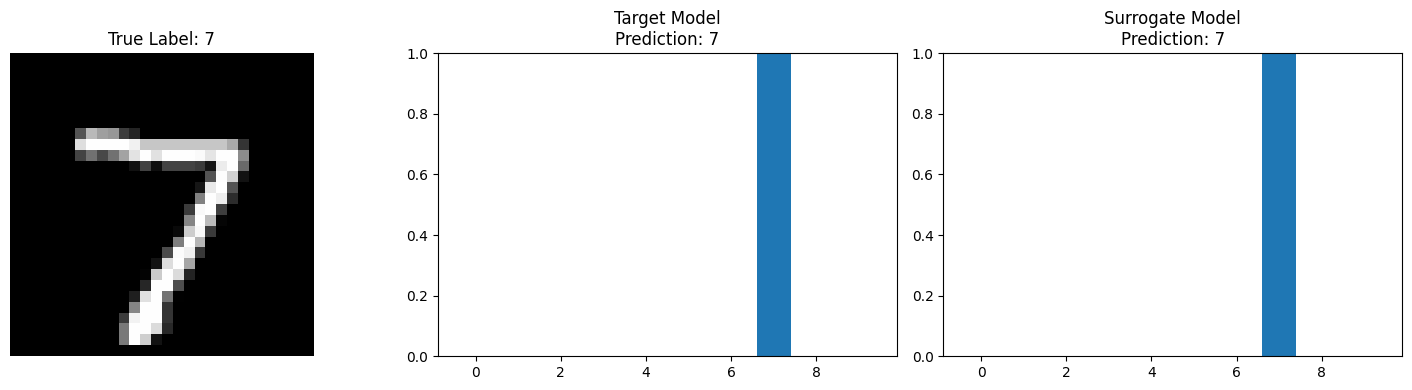

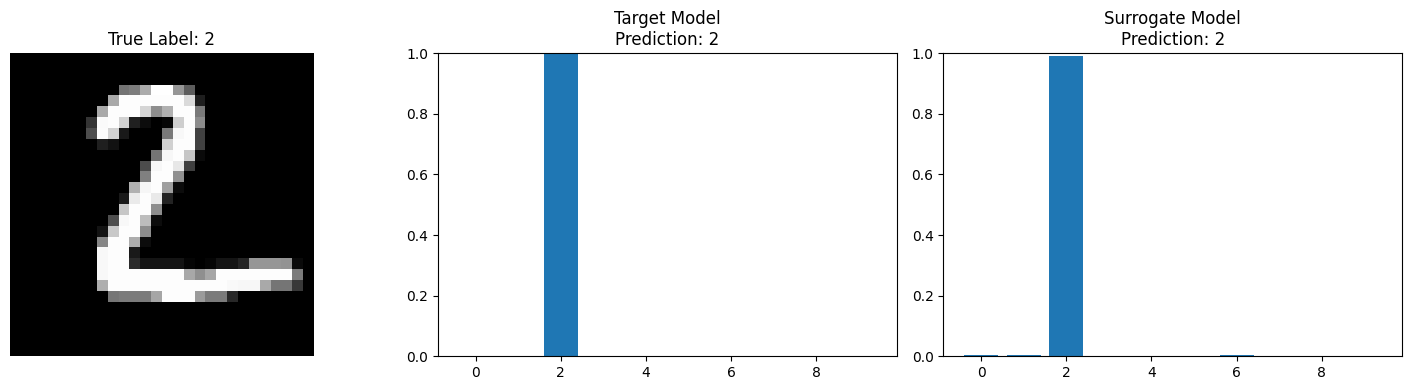

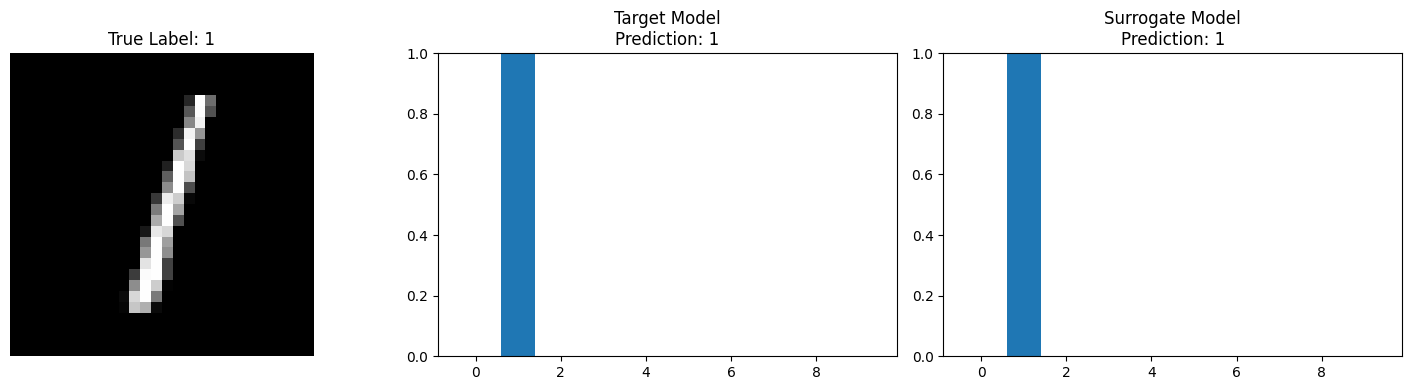


Surrogate model saved as 'stolen_model.keras'


In [69]:
# Visualize examples
print("Visualizing examples...")
for i in range(3):
    plot_comparison(
        x_test[i],
        test_target_preds[i],
        surrogate_preds[i],
        y_test[i]
    )

# Save surrogate model
surrogate_model.save('models/stolen_model.keras')
print("\nSurrogate model saved as 'stolen_model.keras'")